# Taller 2

1. [**Parámetros del kart**](#primero)
1. [**Usar el cálculo de potencia de Clavijo**](#segundo)
1. [**Desempeño en aceleración del kart**](#tercero)
1. [**Desempeño en frenado del kart**](#cuarto)
2. [**Determinar velocidad máxima y aceleración**](#quinto)
3. [**Tiempo y distancia desde velocidad 0 hasta máxima y 0 de nuevo**](#sexto)
1. [**Análisis a diferentes relaciones**](#septimo)
1. [**Conslusiones**](#octavo)
1. [**Referencias**](#noveno)
1. [**Anexos**](#decimo)

In [1]:
#Comandos operativos (se usa para unir las rutas)
import os 

%pylab inline
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#Carpeta para guardar las gráficas
output_dir = os.path.join( '.','output') 

Populating the interactive namespace from numpy and matplotlib


## 1. Parámetros del kart <a name="primero"></a>

In [2]:
d1 = 39 # Dientes plato
d2 = 11 # Dientes piñon 
n = d1/d2 # Relación 
eta = 0.95 # Eficiencia en la transmisión

rt = 0.139 # Radio geométrico de la llanta [m] 
refe = 0.98*rt # Radio efectivo trasero [m]

rho = 1.1955 # Densidad del aire [kg/m^3]
dlld = 0.975 # Distancia entre llantas delanteras [m]
alpi = 0.88 # Altura del piloto sentado [m]
Af = dlld * alpi # Área frontal [m^2]
Ca = 0.89 # Coeficinete de arrastre

Im = 5.3E-3 # Inercia del motor eléctrico [kg^2]
mt = 1.43 # Masa llanta trasera[kg]
md = 1.2 # Masa llanta delantera [kg]
rd = 0.129 # Radio llanta delantera[m]
rrid = 0.0631 # Radio del rin delantero[m]
rrit = rrid # Radio del rin trasero[m]

mbant = 0.7*mt # Masa de la banda en la llanta trasera [kg]
mdisct = 0.3*mt #Masa del disco en la llanta trasera [kg]
mband = 0.7*mt # Masa de la banda en la llanta delantera [kg]
mdiscd = 0.3*mt # Masa del disco en la llanta delantera [kg]

Id = (mband*rd)+(mdiscd*(rd**2-rrid**2))/2 # Inercia de la llanta delantera [kg m^2]
It = (mbant*rt)+(mdisct*(rt**2-rrit**2))/2 # Inercia de la llanta trasera [kg m^2]

reje = 0.02 # Radio del eje de las llantas [m]
meje = 3.832 # Masa del eje de las llantas [kg]
Ieje = (meje*reje**2)/2 # Inercia del eje de las llantas [kg m^2]


mK = 152 # Masa del kart [kg]
mP = 62 # Masa del piloto [kg]
g = 9.81 # Aceleración gravitacional [m/s^2]
pesoK = mK*g  # Peso del kart [N]


Tf = 34 # Torque de frenado[Nm]





## 2. Aproximación de clavijo <a name="segundo"></a>

In [3]:
# Función para calcular el torque que entrega el motor 
def torque(w):
    Pote = ((-0.00000004564538677*w**3)+(0.0001056995459*w**2)+(1.53209191*w))-1.895523696
    T = Pote/(w * pi/30)
    # El motor eléctrico tiene un torque inicial aunque no esté girando por eso se toma el valor
    # de torque medid hasta 50 rpm para cerrar la gráfica en un valor diferente de 0
    if size(w)> 1:
        for i in range(size(T)): 
            if w[i] < 50:
                T[i]=14.31775979799432
            if T[i] > 38:
                T[i] = 38
    # Valor de torque máximo nominal que puede producir el motor
    elif size(w) == 1:
        if T > 38:
            T = 38
    return T

## 3. Desempeño en aceleración del kart <a name="tercero"></a>

In [4]:
# Funciones para establecer el comportamiento dinámico del kart

# Función de fuerza de arrastre
def arraste (V):
    A = 0.5*rho*Af*Ca*V**2
    return A

# Función para determinar la velocidad angular del motor
def omega (Vx,rela):
    w = (Vx*rela/refe)*(60/(2*pi)) # Termina en rpm
    if size(Vx)>1:
        for i in range(size(Vx)):
            if w[i] >=5000:  # Restricción de velocidad angular máxima
                w[i] = 5000
    elif w > 5000:
        w = 5000
        
    return w

# Función para estimar una velocidad lineal del kart
def velx(w,rela):
    r = (w*refe/rela)*(2*pi/60)
    return r

# Función de fuerza de rodadura
def frod (V,w): # la velocidad debe estar en Km/h
    f = 0.01*(1+(V*1/100)) # Factor de rodadura 
    return w*f*pi/30

# Función de fuerza de tracción
def ftra (Torque, rela):
    tra = Torque*rela*eta/refe
    return tra

# Función de masa equivalente en función de la inercia de motor
# Este valor no se modificó para estos análisis
def masar (Imotor,rela):
    equi = ((Imotor*rela**2)+Ieje+2*It+2*Id)/(refe**2)
    return equi

#Aceleración estimada dada una velocidad angular del motor 
def acelteo (Vm,rela):
    Torque = torque(Vm)
    Ftra = ftra(Torque,rela)
    Vx = velx(Vm,rela)
    Frod = frod(Vx*3.6,Vm)
    Farra = arraste(Vx)
    me = masar(Im,rela)+mK+mP
    a = (Ftra-Frod-Farra)/(me)
    return a

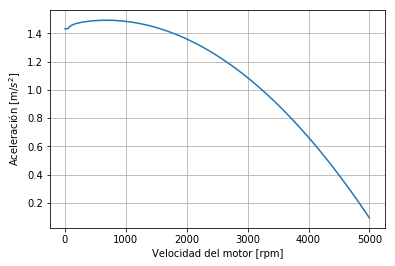

In [5]:
motor = linspace(1,5000,5000)
aT = acelteo(motor,n)
plt.plot(motor,aT)
xlabel('Velocidad del motor [rpm]')
ylabel('Aceleración [m/$s^2$]')
plt.grid()
plt.show()

In [6]:
# Función de aceleración que se integra para hallar los datos de velocidad y posición
def acel (y,t0,rela):
    X, Vx = y
    Vm = omega(Vx,rela)
    Frod = frod(Vx*3.6,Vm)
    Farra = arraste(Vx)
    Torque = torque(Vm)
    Ftra = ftra(Torque,rela)
    me = masar(Im,rela)+mK+mP
    dydt = [Vx,((Ftra-Frod-Farra)/(me))]
    return dydt

In [7]:
# Parámetros para resolver la ecuación
t_0 = 0 # Tiempo inicial [s]
t_1 = 120 # Tiempo final a velocidad máxima[s]
paso = 1000 # Número de datos
x_0 = 0 # Posición inicial [m]
v_0 = 0.01 # Velocidad inicial [m/s]
ini = [x_0,v_0] # Vector de condiciones iniciales
t = linspace(t_0,t_1,paso) #Vector de tiempo a analizar

In [8]:
sol = odeint(acel,ini,t,args=(n,))

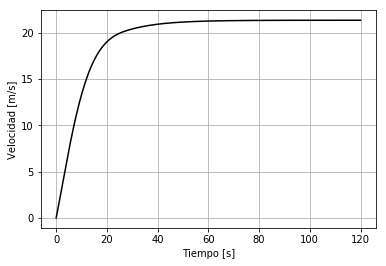

In [9]:
x1 = t
y1 = sol[:,0]
x2 = t
y2 = sol[:,1]
#plt.plot(x1,y1,'k--',label='Posición')
plt.plot(x2,y2, 'k',label='Velocidad')
#plt.legend(loc='best')
xlabel('Tiempo [s]')
ylabel('Velocidad [m/s]')
pylab.savefig(os.path.join(output_dir,'velocidad_prueba_'+str(n)+'.png'), dpi=70)
plt.grid()
plt.show()

Según la gráfica anterior se asume que la velocidad máxima se alcanza cuando:

In [10]:
def vmax (vel):
    ind = 0
    for i in range(1, size(vel)):
        diferencia = vel[i] - vel[i-1]
        if diferencia < 0.0019:
            ind = i
            break
    result = vel[ind]
    return result

Ahora se selecciona solo la parte que se desea graficar

In [11]:
v_max = vmax(sol[:,1])

In [12]:
v_inicio = sol[:,1][sol[:,1] <= v_max]
p_inicio = sol[:,0][0:size(v_inicio)]
p_vmax = p_inicio[-1]
t_inicio = t[0:size(v_inicio)]
t_vmax = t_inicio[-1]

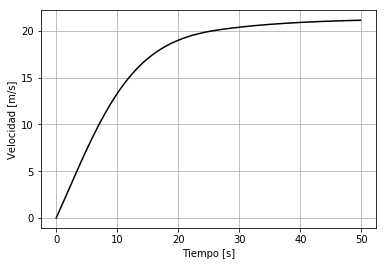

In [13]:
x1 = t_inicio
y1 = p_inicio
x2 = t_inicio
y2 = v_inicio
#plt.plot(x1,y1,'k--',label='Posición')
plt.plot(x2,y2, 'k')
plt.legend(loc='best')
xlabel('Tiempo [s]')
ylabel('Velocidad [m/s]')
pylab.savefig(os.path.join(output_dir,'velocidadMax_prueba_'+str(n)+'.png'), dpi=70)
plt.grid()
plt.show()

## 4. Desempeño en desaceleración del kart <a name="cuarto"></a>

In [14]:
# Función de frenado que se integra para encontrar velocidad y posición
def desacel (y,t0,rela):
    X, Vx = y
    Vm = omega(Vx,rela)
    Frod = frod(Vx*3.6,Vm)
    Farra = arraste(Vx)
    Torque = torque(Vm)
    Fb = -Tf/refe
    me = masar(Im,rela)+mK+mP
    dydt = [Vx,((Fb-Frod-Farra)/(me))]
    return dydt

In [15]:
# Parámetros para resolver la ecuación
t_2 = 100 #Tiempo final hasta que la velocidad vuelve a 0 [s]
t2 = linspace(t_vmax,t_2,paso)
inif = [p_vmax,v_max]

In [16]:
sol2 = odeint(desacel,inif,t2,  args = (n,))

Es necesario seleccionar los datos para que se muestre solo hasta el momento en que la velocidad llega a 0.

In [17]:
# Selección de velocidad hasta llegar a 0
frenado =sol2[:,1][sol2[:,1]>=0]
p_frenado = sol2[:,0][0:size(frenado)]
p_final = p_frenado[-1]
t_frenado = t2[0:size(frenado)]
t_final = t_frenado[-1]

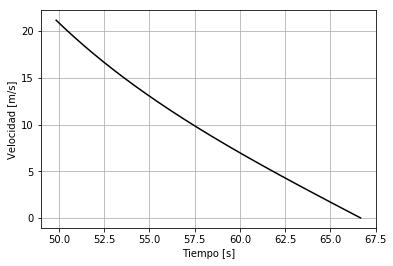

In [18]:
x1 = t_frenado
y1 = p_frenado
x2 = t_frenado
y2 = frenado
#plt.plot(x1,y1,'k--',label='Posición')
plt.plot(x2,y2, 'k')
plt.legend(loc='best')
xlabel('Tiempo [s]')
ylabel('Velocidad [m/s]')
pylab.savefig(os.path.join(output_dir,'velocidadFre_prueba_'+str(n)+'.png'), dpi=70)
plt.grid()
plt.show()

## 5. Velocidad máxima y aceleración <a name="quinto"></a>

La velocidad máxima se determinó al final del [punto 3](#tercero), pero ahora para los valores de velocidad encontrados por la integración teórica se debe determinar una aceleración dada la siguiente función:

In [19]:
#Aceleración estimada dada una velocidad lineal del kart 
def acelkart (vkart,rela):
    Vm = omega(vkart,rela)
    Torque = torque(Vm)
    Ftra = ftra(Torque,rela)
    Frod = frod(vkart*3.6,Vm)
    Farra = arraste(vkart)
    me = masar(Im,rela)+mK+mP
    a = (Ftra-Frod-Farra)/(me)
    return a

In [20]:
aKart = acelkart(v_inicio,n)
indamax = argmax(aKart)
amax = aKart[indamax]
tamax = t_inicio[indamax]

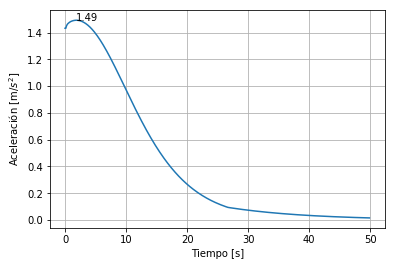

In [21]:
plt.plot(t_inicio,aKart)
xlabel('Tiempo [s]')
ylabel('Aceleración [m/$s^2$]')
pylab.savefig(os.path.join(output_dir,'AceleracionVmax_prueba_'+str(n)+'.png'), dpi=70)
plt.annotate(("%.2f" % amax), xy = (tamax, amax))
plt.grid()
plt.show()

In [22]:
def comportamiento (velr, vel,pos, tie, acel):
    return print('La velocidad máxima alcanzada en 120s para una relacion de ' + '%.2f' % n +' fue ' + '%.2f' % velr + "\n" 
                 'La velocidad máxima según el criterio establecido fue ' + '%.2f' % vel + "\n" 
                 + 'La distancia lineal recorrida hasta alcanzar la velocidad máxima fue ' + '%.2f' % pos + "\n" 
                 + 'El tiempo que se demoró hasta alcanzar la velocidad máxima fue ' + '%.2f' % tie + "\n"
                + 'La aceleración máxima calculada en el sistema fue de ' + '%.2f' %acel)

In [23]:
comportamiento(sol[:,1][-1],v_max,p_vmax,t_vmax,amax)

La velocidad máxima alcanzada en 120s para una relacion de 3.55 fue 21.33
La velocidad máxima según el criterio establecido fue 21.14
La distancia lineal recorrida hasta alcanzar la velocidad máxima fue 850.88
El tiempo que se demoró hasta alcanzar la velocidad máxima fue 49.85
La aceleración máxima calculada en el sistema fue de 1.49


## 6. Modelo de tiempo y distancia <a name="sexto"></a>

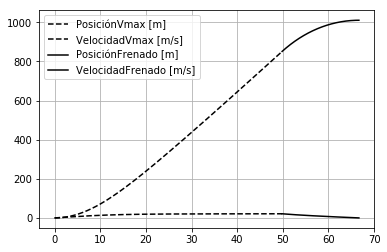

In [24]:
x0 = t_inicio
y0 = p_inicio
x1 = t_inicio
y1 = v_inicio
x2 = t_frenado
y2 = p_frenado
x3 = t_frenado
y3 = frenado

plt.plot(x0,y0,'k--',label='PosiciónVmax [m]')
plt.plot(x1,y1,'k--',label='VelocidadVmax [m/s]' )
plt.plot(x2,y2, 'k',label='PosiciónFrenado [m]')
plt.plot(x3,y3, 'k',label='VelocidadFrenado [m/s]')
plt.legend(loc='best')
pylab.savefig(os.path.join(output_dir,'Resultados_prueba_'+str(n)+'.png'), dpi=70)
plt.grid()
plt.show()

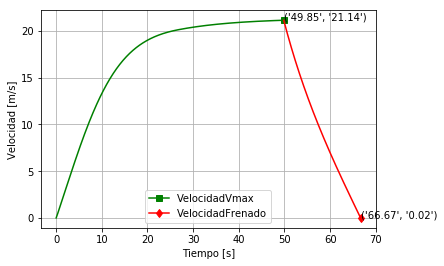

In [25]:
plt.plot(x1,y1,'-gs',label='VelocidadVmax', markevery = [-1])
plt.plot(x3,y3, '-rd',label='VelocidadFrenado',markevery = [-1])
plt.legend(loc='best')
plt.annotate(("%.2f" % x1[-1],"%.2f" % y1[-1]), xy = (x1[-1], y1[-1]), textcoords ='data' )
plt.annotate(("%.2f" % x3[-1],"%.2f" % y3[-1]), xy = (x3[-1], y3[-1]), textcoords ='data' )
xlabel('Tiempo [s]')
ylabel('Velocidad [m/s]')
pylab.savefig(os.path.join(output_dir,'velocidadtotal_prueba_'+str(n)+'.png'), dpi=70)
plt.grid()
plt.show()

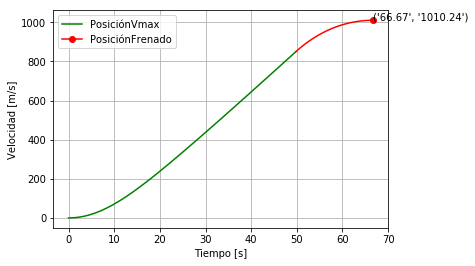

In [26]:
plt.plot(x0,y0,'g',label='PosiciónVmax')
plt.plot(x2,y2, '-ro',label='PosiciónFrenado', markevery = [-1])
plt.legend(loc='best')
plt.annotate(("%.2f" % x2[-1],"%.2f" % y2[-1]), xy = (x2[-1], y2[-1]), textcoords ='data' )
xlabel('Tiempo [s]')
ylabel('Velocidad [m/s]')
pylab.savefig(os.path.join(output_dir,'posiciontotal_prueba_'+str(n)+'.png'), dpi=70)
plt.grid()
plt.show()

## 7. Análisis a diferentes relaciones de plato y piñon <a name="septimo"></a>

Este trabajo tiene por objetivo evaluar el comportamiento del kart eléctrico en aceleración hasta la máxima velocidad y con su respectiva desaceleración por medio de los frenos hasta velocidad 0 m/s **usando diferentes relaciones entre el plato y el piñón**. Para esto se tomaron las ecuaciones que definen el comportamiento del kart [[1]](#ref:1), la función de potencia (para hallar el torque) en función de la velocidad angular del motor [[2]](#ref:2)[[3]](#ref:3) y los datos del kart planteados por Cordoba [[4]](#ref:4)[[5]](#ref:5). A partir de estos valores iniciales se determinó el comportamiento para la primera relación (n1 = 3.55) y con la tabla de relaciones para karts [[6]](ref:6) se estudió el comportamiento para otras 5 relaciones, planteadas en la [Tabla 1.](#tab:1)

###### Tabla 1. Relaciones evaluadas para el comportamiento del kart. <a name="tab:1"></a>
| Prueba | Dientes Piñón | Dientes Plato | Relación (n) |
|--------|---------------|---------------|--------------|
| 1      | 11            | 39            | 3.55         |
| 2      | 11            | 44            | 4.00         |
| 3      | 11            | 49            | 4.44         |
| 4      | 11            | 59            | 5.36         |
| 5      | 11            | 69            | 6.27         |
| 6      | 11            | 79            | 7.18         |


Cabe aclarar que para las relaciones **n2 = 4 y n3 = 4.44** se siguieron las relaciones planteadas en [[6]](#ref:6) con 60 dientes en el plato y 15 dientes en el piñon para n2 y 80 dientes en el plato y 18 dientes en el piñón para n3 pero que son **equivalentes** para los valores de la [Tabla 1](#tab:1). A partir de estas relaciones, se integró la función de aceleración planteada en las funciones de la [sección 3](#tercero) y se determinó la velocidad máxima que podría alcanzar el kart en un lapso de 120 segundos.

## 8. Conclusiones <a name="octavo"></a>

## 9. Referencias <a name="noveno"></a>

[1] [A. Gonzalez, simulador_00.ipynb, Bogotá](https://github.com/andresgm/Herramientas-Computacionales/blob/master/03_taller02/simulador_00.ipynb)  <a name="ref:1"></a>

[2] [D. Clavijo, Análisis simulación e implementación de mejora del rendimiento para un kart eléctrico, Bogotá, Universidad de los Andes, Mayo 2017](https://github.com/andresgm/Herramientas-Computacionales/blob/master/03_taller02/referencias/referencias/clavijo.pdf) <a name="ref:2"></a>

[3] [D. Clavijo, potencia.m, Bogotá](https://github.com/andresgm/Herramientas-Computacionales/blob/master/03_taller02/referencias/clavijo/potencia.m) <a name="ref:3"></a>

[4] [M. Cordoba, Diseño de un tren de potencia para un kart eléctrico](https://github.com/andresgm/Herramientas-Computacionales/blob/master/03_taller02/referencias/referencias/cordoba.pdf) <a name="ref:4"></a>

[5] [M. Cordoba, kart_dynamics.ipynb, Bogotá](https://github.com/andresgm/Herramientas-Computacionales/blob/master/03_taller02/referencias/cordoba/kart_dynamics.ipynb) <a name="ref:5"></a>

[6] [Comet kart sales, Gear Ratio Chart](https://cometkartsales.com/skin/comet/images/photos/CometGearChart.pdf) <a name="ref:6"></a>


## 10. Anexos <a name="decimo"></a>

#### 10.1 Relaciones de plato y piñón analizadas: <a name="diezuno"></a>

In [27]:
#Primera relación [5]
d1p = 39 # Dientes plato
d1pi = 11 # Dientes piñon 
n1 = d1p/d1pi # Relación 

#Segunda relación (equivalente a un plato y  piñón de 44 y 11 dientes respectivamente) pero tomado de la tabla en [6]
d2p = 60# Dientes plato
d2pi = 15 # Dientes piñon 
n2 = d2p/d2pi # Relación 

#Tercera relación (equivalente a un plato y  piñón de 49 y 11 dientes respectivamente) pero tomada de la tabla [6]
d3p = 80 # Dientes plato
d3pi = 18 # Dientes piñon 
n3 = d3p/d3pi # Relación 

#Cuarta relación [6]
d4p = 59 # Dientes plato
d4pi = 11 # Dientes piñon 
n4 = d4p/d4pi # Relación 

#Quinta relación [6]
d5p = 69 # Dientes plato
d5pi = 11 # Dientes piñon 
n5 = d5p/d5pi # Relación 

#Sexta relación [6]
d6p = 79 # Dientes plato
d6pi = 11 # Dientes piñon 
n6 = d6p/d6pi # Relación 


#### 10.2 En aceleración  <a name="diezdos"></a>

Se resuelven las integrales variando las relaciones en aceleración

In [28]:
#En aceleración
inte1 = odeint(acel,ini,t,args = (n1,))
inte2 = odeint(acel,ini,t,args = (n2,))
inte3 = odeint(acel,ini,t,args = (n3,))
inte4 = odeint(acel,ini,t,args = (n4,))
inte5 = odeint(acel,ini,t,args = (n5,))
inte6 = odeint(acel,ini,t,args = (n6,))

# Velocidades máximas alcanzadas
vmaxinte1 = inte1[:,1][-1]
vmaxinte2 = inte2[:,1][-1]
vmaxinte3 = inte3[:,1][-1]
vmaxinte4 = inte4[:,1][-1]
vmaxinte5 = inte5[:,1][-1]
vmaxinte6 = inte6[:,1][-1]

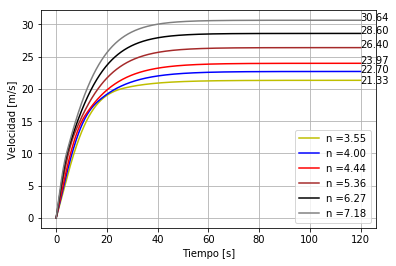

In [29]:
plt.plot(t,inte1[:,1], 'y',label= 'n =' + '%.2f' % n1)
plt.plot(t,inte2[:,1], 'b',label= 'n =' + '%.2f' % n2)
plt.plot(t,inte3[:,1], 'r',label= 'n =' + '%.2f' % n3)
plt.plot(t,inte4[:,1], 'brown',label= 'n =' + '%.2f' % n4)
plt.plot(t,inte5[:,1], 'k',label = 'n =' + '%.2f' % n5)
plt.plot(t,inte6[:,1], 'grey',label = 'n =' + '%.2f' % n6)
plt.annotate(("%.2f" % vmaxinte1), xy = (120, vmaxinte1-0.5))
plt.annotate(("%.2f" % vmaxinte2), xy = (120, vmaxinte2-0.2))
plt.annotate(("%.2f" % vmaxinte3), xy = (120, vmaxinte3))
plt.annotate(("%.2f" % vmaxinte4), xy = (120, vmaxinte4))
plt.annotate(("%.2f" % vmaxinte5), xy = (120, vmaxinte5))
plt.annotate(("%.2f" % vmaxinte6), xy = (120, vmaxinte6))
plt.legend(loc='best')
xlabel('Tiempo [s]')
ylabel('Velocidad [m/s]')
pylab.savefig(os.path.join(output_dir,'velocidad_relacion_.png'), dpi=70)
plt.grid()
plt.show()

Se emplea el criterio definido previamente en la función vmax para definir cuándo el carro alcanza la máxima velocidad 

In [30]:
v_max1 = vmax(inte1[:,1])
v_max2 = vmax(inte2[:,1])
v_max3 = vmax(inte3[:,1])
v_max4 = vmax(inte4[:,1])
v_max5 = vmax(inte5[:,1])
v_max6 = vmax(inte6[:,1])

Se crean los nuevos vectores con los datos hasta la nueva velocidad máxima

In [31]:
#Velocidades
v_inicio1 = inte1[:,1][inte1[:,1] <= v_max1]
v_inicio2 = inte2[:,1][inte2[:,1] <= v_max2]
v_inicio3 = inte3[:,1][inte3[:,1] <= v_max3]
v_inicio4 = inte4[:,1][inte4[:,1] <= v_max4]
v_inicio5 = inte5[:,1][inte5[:,1] <= v_max5]
v_inicio6 = inte6[:,1][inte6[:,1] <= v_max6]

#Posiciones
p_inicio1 = inte1[:,0][0:size(v_inicio1)]
p_inicio2 = inte2[:,0][0:size(v_inicio2)]
p_inicio3 = inte3[:,0][0:size(v_inicio3)]
p_inicio4 = inte4[:,0][0:size(v_inicio4)]
p_inicio5 = inte5[:,0][0:size(v_inicio5)]
p_inicio6 = inte6[:,0][0:size(v_inicio6)]

#Tiempos
t_inicio1 = t[0:size(v_inicio1)]
t_inicio2 = t[0:size(v_inicio2)]
t_inicio3 = t[0:size(v_inicio3)]
t_inicio4 = t[0:size(v_inicio4)]
t_inicio5 = t[0:size(v_inicio5)]
t_inicio6 = t[0:size(v_inicio6)]

Datos de comportamiento en aceleración

In [32]:
#Distancias recorridas
p_vmax1 = p_inicio1[-1]
p_vmax2 = p_inicio2[-1]
p_vmax3 = p_inicio3[-1]
p_vmax4 = p_inicio4[-1]
p_vmax5 = p_inicio5[-1]
p_vmax6 = p_inicio6[-1]

#Tiempo en aceleración
t_vmax1 = t_inicio1[-1]
t_vmax2 = t_inicio2[-1]
t_vmax3 = t_inicio3[-1]
t_vmax4 = t_inicio4[-1]
t_vmax5 = t_inicio5[-1]
t_vmax6 = t_inicio6[-1]

Gráfica comparanado velocidades de aceleración dependiendo relación

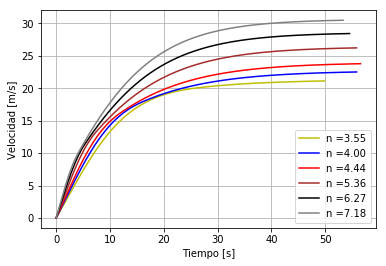

In [33]:
plt.plot(t_inicio1,v_inicio1,'y', label = 'n =' + '%.2f' % n1)
plt.plot(t_inicio2,v_inicio2, 'b',label = 'n =' + '%.2f' % n2)
plt.plot(t_inicio3,v_inicio3, 'r',label = 'n =' + '%.2f' % n3)
plt.plot(t_inicio4,v_inicio4, 'brown',label = 'n =' + '%.2f' % n4)
plt.plot(t_inicio5,v_inicio5, 'k',label = 'n =' + '%.2f' % n5)
plt.plot(t_inicio6,v_inicio6, 'grey',label = 'n =' + '%.2f' % n6)
plt.legend(loc='best')
xlabel('Tiempo [s]')
ylabel('Velocidad [m/s]')
pylab.savefig(os.path.join(output_dir,'velocidadMax_relacion_.png'), dpi=70)
plt.grid()
plt.show()

Aceleraciones generadas

In [34]:
#Aceleraciones genreadas a partir de las velocidades encontradas 
aKart1 = acelkart(v_inicio1,n1)
aKart2 = acelkart(v_inicio2,n2)
aKart3 = acelkart(v_inicio3,n3)
aKart4 = acelkart(v_inicio4,n4)
aKart5 = acelkart(v_inicio5,n5)
aKart6 = acelkart(v_inicio6,n6)

#Puntos de aceleración máxima
#Indices dentro del vector
indamax1 = argmax(aKart1)
indamax2 = argmax(aKart2)
indamax3 = argmax(aKart3)
indamax4 = argmax(aKart4)
indamax5 = argmax(aKart5)
indamax6 = argmax(aKart6)

#Valores de aceleración máxima
amax1 = aKart1[indamax1]
amax2 = aKart2[indamax2]
amax3 = aKart3[indamax3]
amax4 = aKart4[indamax4]
amax5 = aKart5[indamax5]
amax6 = aKart6[indamax6]

#Tiempo en el que ocurre
tamax1 = t_inicio1[indamax1]
tamax2 = t_inicio2[indamax2]
tamax3 = t_inicio3[indamax3]
tamax4 = t_inicio4[indamax4]
tamax5 = t_inicio5[indamax5]
tamax6 = t_inicio6[indamax6]

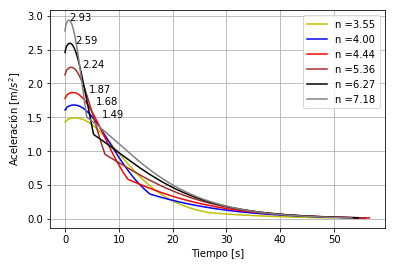

In [35]:
plt.plot(t_inicio1,aKart1,'y', label = 'n =' + '%.2f' % n1)
plt.plot(t_inicio2,aKart2,'b', label = 'n =' + '%.2f' % n2)
plt.plot(t_inicio3,aKart3,'r', label = 'n =' + '%.2f' % n3)
plt.plot(t_inicio4,aKart4,'brown', label = 'n =' + '%.2f' % n4)
plt.plot(t_inicio5,aKart5,'k', label = 'n =' + '%.2f' % n5)
plt.plot(t_inicio6,aKart6,'grey', label = 'n =' + '%.2f' % n6)
xlabel('Tiempo [s]')
ylabel('Aceleración [m/$s^2$]')
plt.annotate(("%.2f" % amax1), xy = (tamax1+5, amax1))
plt.annotate(("%.2f" % amax2), xy = (tamax2+4, amax2))
plt.annotate(("%.2f" % amax3), xy = (tamax3+3, amax3))
plt.annotate(("%.2f" % amax4), xy = (tamax4+2, amax4))
plt.annotate(("%.2f" % amax5), xy = (tamax5+1, amax5))
plt.annotate(("%.2f" % amax6), xy = (tamax6, amax6))
plt.legend(loc='best')
pylab.savefig(os.path.join(output_dir,'AceleracionVmax_relacion_.png'), dpi=70)
plt.grid()
plt.show()

In [36]:
print('\033[1m'+'Para n = ' + '%.2f' % n1 + ' el comportamiento es:'+'\033[0m')
comportamiento(vmaxinte1,v_max1,p_vmax1,t_vmax1,amax1)

print('\033[1m'+'Para n = ' + '%.2f' % n2 + ' el comportamiento es:'+'\033[0m')
comportamiento(vmaxinte2,v_max2,p_vmax2,t_vmax2,amax2)

print('\033[1m'+'Para n = ' + '%.2f' % n3 + ' el comportamiento es:'+'\033[0m')
comportamiento(vmaxinte3,v_max3,p_vmax3,t_vmax3,amax3)

print('\033[1m'+'Para n = ' + '%.2f' % n4 + ' el comportamiento es:'+'\033[0m')
comportamiento(vmaxinte4,v_max4,p_vmax4,t_vmax4,amax4)

print('\033[1m'+'Para n = ' + '%.2f' % n5 + ' el comportamiento es:'+'\033[0m')
comportamiento(vmaxinte5,v_max5,p_vmax5,t_vmax5,amax5)

print('\033[1m'+'Para n = ' + '%.2f' % n6 + ' el comportamiento es:'+'\033[0m')
comportamiento(vmaxinte6,v_max6,p_vmax6,t_vmax6,amax6)

Para n = 3.55 el comportamiento es:
La velocidad máxima alcanzada en 120s para una relacion de 3.55 fue 21.33
La velocidad máxima según el criterio establecido fue 21.14
La distancia lineal recorrida hasta alcanzar la velocidad máxima fue 850.88
El tiempo que se demoró hasta alcanzar la velocidad máxima fue 49.85
La aceleración máxima calculada en el sistema fue de 1.49
Para n = 4.00 el comportamiento es:
La velocidad máxima alcanzada en 120s para una relacion de 3.55 fue 22.70
La velocidad máxima según el criterio establecido fue 22.52
La distancia lineal recorrida hasta alcanzar la velocidad máxima fue 1023.30
El tiempo que se demoró hasta alcanzar la velocidad máxima fue 55.86
La aceleración máxima calculada en el sistema fue de 1.68
Para n = 4.44 el comportamiento es:
La velocidad máxima alcanzada en 120s para una relacion de 3.55 fue 23.97
La velocidad máxima según el criterio establecido fue 23.79
La distancia lineal recorrida hasta alcanzar la velocidad máxima fue 1090.71
El tie

#### 10.3 En desaceleración  <a name="dieztres"></a>

In [37]:
#Condiciones iniciales 
t_2 = 100 #Tiempo final hasta que la velocidad vuelve a 0 [s]

#Tiempos de integración
tf1 = linspace(t_vmax1,t_2,paso)
tf2 = linspace(t_vmax2,t_2,paso)
tf3 = linspace(t_vmax3,t_2,paso)
tf4 = linspace(t_vmax4,t_2,paso)
tf5 = linspace(t_vmax5,t_2,paso)
tf6 = linspace(t_vmax6,t_2,paso)

#Condiciones iniciales
inif1 = [p_vmax1,v_max1]
inif2 = [p_vmax2,v_max2]
inif3 = [p_vmax3,v_max3]
inif4 = [p_vmax4,v_max4]
inif5 = [p_vmax5,v_max5]
inif6 = [p_vmax6,v_max6]

#Soluciones
desinte1 = odeint(desacel,inif1,tf1,args = (n1,))
desinte2 = odeint(desacel,inif2,tf2,args = (n2,))
desinte3 = odeint(desacel,inif3,tf3,args = (n3,))
desinte4 = odeint(desacel,inif4,tf4,args = (n4,))
desinte5 = odeint(desacel,inif5,tf5,args = (n5,))
desinte6 = odeint(desacel,inif6,tf6,args = (n6,))

In [38]:
# Velocidades de frenado
frenado1 =desinte1[:,1][desinte1[:,1]>=0]
frenado2 =desinte2[:,1][desinte2[:,1]>=0]
frenado3 =desinte3[:,1][desinte3[:,1]>=0]
frenado4 =desinte4[:,1][desinte4[:,1]>=0]
frenado5 =desinte5[:,1][desinte5[:,1]>=0]
frenado6 =desinte6[:,1][desinte6[:,1]>=0]

# Distancias recorridas en frenado (esta tiene en cuenta)
p_frenado1 = desinte1[:,0][0:size(frenado1)]
p_frenado2 = desinte2[:,0][0:size(frenado2)]
p_frenado3 = desinte3[:,0][0:size(frenado3)]
p_frenado4 = desinte4[:,0][0:size(frenado4)]
p_frenado5 = desinte5[:,0][0:size(frenado5)]
p_frenado6 = desinte6[:,0][0:size(frenado6)]

# Tiempos de frenado 
t_frenado1 = tf1[0:size(frenado1)]
t_frenado2 = tf2[0:size(frenado2)]
t_frenado3 = tf3[0:size(frenado3)]
t_frenado4 = tf4[0:size(frenado4)]
t_frenado5 = tf5[0:size(frenado5)]
t_frenado6 = tf6[0:size(frenado6)]

Gráfica comparando el comportamiento en frenado para diferentes relaciones

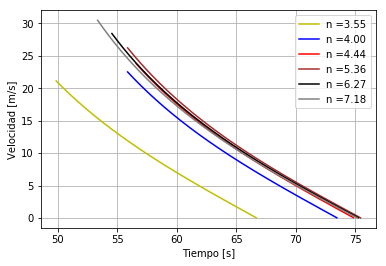

In [39]:
plt.plot(t_frenado1,frenado1,'y', label = 'n =' + '%.2f' % n1)
plt.plot(t_frenado2,frenado2, 'b',label = 'n =' + '%.2f' % n2)
plt.plot(t_frenado3,frenado3, 'r',label = 'n =' + '%.2f' % n3)
plt.plot(t_frenado4,frenado4, 'brown',label = 'n =' + '%.2f' % n4)
plt.plot(t_frenado5,frenado5, 'k',label = 'n =' + '%.2f' % n5)
plt.plot(t_frenado6,frenado6, 'grey',label = 'n =' + '%.2f' % n6)
plt.legend(loc='best')
xlabel('Tiempo [s]')
ylabel('Velocidad [m/s]')
pylab.savefig(os.path.join(output_dir,'velocidadFrenado_relacion_.png'), dpi=70)
plt.grid()
plt.show()

#### 10.4 Simulación de velocidad para aceleración y desaceleración  <a name="diezcuatro"></a>

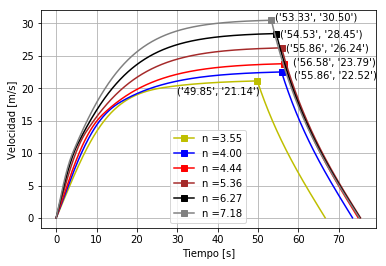

In [40]:
plt.plot(t_inicio1,v_inicio1,'-ys', label = 'n =' + '%.2f' % n1,markevery=[-1])
plt.plot(t_inicio2,v_inicio2,'-bs',label = 'n =' + '%.2f' % n2,markevery=[-1])
plt.plot(t_inicio3,v_inicio3,'-rs',label = 'n =' + '%.2f' % n3,markevery=[-1])
plt.plot(t_inicio4,v_inicio4,color='brown',marker='s',label = 'n =' + '%.2f' % n4,markevery=[-1])
plt.plot(t_inicio5,v_inicio5,'-ks',label = 'n =' + '%.2f' % n5,markevery=[-1])
plt.plot(t_inicio6,v_inicio6,color='grey',marker='s',label = 'n =' + '%.2f' % n6,markevery=[-1])
plt.plot(t_frenado1,frenado1,'-y')
plt.plot(t_frenado2,frenado2,'-b')
plt.plot(t_frenado3,frenado3,'-r')
plt.plot(t_frenado4,frenado4,color='brown')
plt.plot(t_frenado5,frenado5,'-k')
plt.plot(t_frenado6,frenado6,color='grey')
plt.annotate(("%.2f" % t_inicio1[-1],"%.2f" % v_inicio1[-1]), xy = (t_inicio1[-1]-20, v_inicio1[-1]-2))
plt.annotate(("%.2f" % t_inicio2[-1],"%.2f" % v_inicio2[-1]), xy = (t_inicio2[-1]+3, v_inicio2[-1]-1))
plt.annotate(("%.2f" % t_inicio3[-1],"%.2f" % v_inicio3[-1]), xy = (t_inicio3[-1]+2, v_inicio3[-1]-0.25))
plt.annotate(("%.2f" % t_inicio4[-1],"%.2f" % v_inicio4[-1]), xy = (t_inicio4[-1]+1, v_inicio4[-1]-0.5))
plt.annotate(("%.2f" % t_inicio5[-1],"%.2f" % v_inicio5[-1]), xy = (t_inicio5[-1]+1, v_inicio5[-1]-0.5))
plt.annotate(("%.2f" % t_inicio6[-1],"%.2f" % v_inicio6[-1]), xy = (t_inicio6[-1]+1, v_inicio6[-1]))
plt.legend(loc='lower center')
xlabel('Tiempo [s]')
ylabel('Velocidad [m/s]')
pylab.savefig(os.path.join(output_dir,'SimulacionVelocidad_relacion_.png'), dpi=70)
plt.grid()
plt.show()

Simulación de distancia y tiempo total de recorrido en aceleración y desaceleración

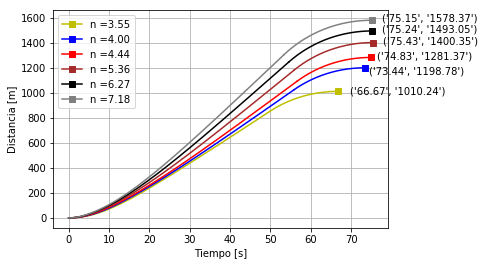

In [41]:
plt.plot(t_inicio1,p_inicio1,'-y')
plt.plot(t_inicio2,p_inicio2,'-b')
plt.plot(t_inicio3,p_inicio3,'-r')
plt.plot(t_inicio4,p_inicio4,color='brown')
plt.plot(t_inicio5,p_inicio5,'-k')
plt.plot(t_inicio6,p_inicio6,color='grey')
plt.plot(t_frenado1,p_frenado1,'-ys', label = 'n =' + '%.2f' % n1,markevery=[-1])
plt.plot(t_frenado2,p_frenado2,'-bs',label = 'n =' + '%.2f' % n2,markevery=[-1])
plt.plot(t_frenado3,p_frenado3,'-rs',label = 'n =' + '%.2f' % n3,markevery=[-1])
plt.plot(t_frenado4,p_frenado4,color='brown',marker='s',label = 'n =' + '%.2f' % n4,markevery=[-1])
plt.plot(t_frenado5,p_frenado5,'-ks',label = 'n =' + '%.2f' % n5,markevery=[-1])
plt.plot(t_frenado6,p_frenado6,color='grey',marker='s',label = 'n =' + '%.2f' % n6,markevery=[-1])
plt.annotate(("%.2f" % t_frenado1[-1],"%.2f" % p_frenado1[-1]), xy = (t_frenado1[-1]+3, p_frenado1[-1]-20))
plt.annotate(("%.2f" % t_frenado2[-1],"%.2f" % p_frenado2[-1]), xy = (t_frenado2[-1]+1, p_frenado2[-1]-50))
plt.annotate(("%.2f" % t_frenado3[-1],"%.2f" % p_frenado3[-1]), xy = (t_frenado3[-1]+1.5, p_frenado3[-1]-15))
plt.annotate(("%.2f" % t_frenado4[-1],"%.2f" % p_frenado4[-1]), xy = (t_frenado4[-1]+2.5, p_frenado4[-1]-10))
plt.annotate(("%.2f" % t_frenado5[-1],"%.2f" % p_frenado5[-1]), xy = (t_frenado5[-1]+2.5, p_frenado5[-1]-10))
plt.annotate(("%.2f" % t_frenado6[-1],"%.2f" % p_frenado6[-1]), xy = (t_frenado6[-1]+2.5, p_frenado6[-1]-10))
plt.legend(loc='best')
xlabel('Tiempo [s]')
ylabel('Distancia [m]')
pylab.savefig(os.path.join(output_dir,'SimulacionPosicion_relacion_.png'), dpi=70)
plt.grid()
plt.show()